In [402]:
import numpy as np 
import seaborn as sea 
import matplotlib.pyplot as plt
from pyprind.progbar import ProgBar

`Algoritmo MLP`

In [403]:
from sklearn.metrics import mean_absolute_error
from scipy.special import softmax

In [404]:
class MLP:
    def __init__(self, X, y, xval, yval, tipo='cl', camadas_ocultas=2,
                 batch_size=32, epochs=100, loss=[mean_absolute_error],
                 lr=1e-3, momentum=0.9, seed=42):

        # dados
        self.X = X
        self.y = y
        self.xval = xval
        self.yval = yval

        self.epochs = epochs
        self.batch_size = batch_size
        self.tipo = tipo
        self.loss = loss
        self.lr = lr
        self.momentum = momentum

        # dimensões
        self.n_features = X.shape[1]
        
        # Ajuste para a dimensão de saída
        if tipo == 'cl':
            self.classes = len(np.unique(y))
            output_dim = self.classes
        else:
            self.classes = 1
            output_dim = 1
        
        # inicialização aleatória com seed definida
        rnd = np.random.RandomState(seed=seed)
    
        self.n_hidden = camadas_ocultas

        self.W = rnd.normal(scale=0.1, size=(self.n_hidden, self.n_features))
        self.b1 = np.zeros((self.n_hidden, 1))

        self.M = rnd.normal(scale=0.1, size=(output_dim, self.n_hidden))
        self.b2 = np.zeros((output_dim, 1))

        # momentum
        self.vW = np.zeros_like(self.W)
        self.vb1 = np.zeros_like(self.b1)
        self.vM = np.zeros_like(self.M)
        self.vb2 = np.zeros_like(self.b2)


    # Minilotes aleatórios do SGD
    def batchs(self, x, y):
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)

        for idx in range(0, indices.shape[0] - self.batch_size + 1, self.batch_size):
            idx_batch = indices[idx:idx + self.batch_size]
            yield x[idx_batch], y[idx_batch]


    # Treinamento
    def ajuste(self):
        progresso = ProgBar(self.epochs, monitor=True)
        self.perdas = [[] for _ in self.loss]
        self.perdas_val = [[] for _ in self.loss]

        for _ in range(self.epochs):
            perdas_epoch = [[] for _ in self.loss]

            for x_i, y_i in self.batchs(self.X, self.y):
                self.propagacao(x_i, y_i)

                # cálculo da perda do batch
                if self.tipo == 'cl':
            
                    ytrue_labels = y_i
                    ypred_labels = np.argmax(self.y_hat, axis=0)
                    
                    for e, lf in enumerate(self.loss):
                        perdas_epoch[e].append(lf(ytrue_labels, ypred_labels))
                        
                else: #
                    y_r = y_i.reshape(-1) 
                    y_hat_r = self.y_hat.reshape(-1)
                    for e, lf in enumerate(self.loss):
                        perdas_epoch[e].append(lf(y_r, y_hat_r))

                self.backpropagacao(x_i, y_i)

            # média da perda por epoch
            for e in range(len(self.loss)):
                self.perdas[e].append(np.mean(perdas_epoch[e]))

            # validação
            u_val = self.W @ self.xval.T + self.b1
            r_val = self.M @ u_val + self.b2

            if self.tipo == 'cl':
                y_hat_val = softmax(r_val)

                ytrue_val = self.yval
                ypred_val = np.argmax(y_hat_val, axis=0)
                
                for e, lf in enumerate(self.loss):
                    self.perdas_val[e].append(lf(ytrue_val, ypred_val))
            else:
                y_hat_val = r_val
                y_r_val = self.yval.reshape(-1)
                y_hat_val_r = y_hat_val.reshape(-1)
                for e, lf in enumerate(self.loss):
                    self.perdas_val[e].append(lf(y_r_val, y_hat_val_r))

            progresso.update(1)


    # Forward
    def propagacao(self, x_i, y_i):
        self.x_i = x_i.T 
        self.y_i = y_i
      
        self.u = self.W @ self.x_i + self.b1
       
        self.r = self.M @ self.u + self.b2

        if self.tipo == 'cl':
            self.y_hat = softmax(self.r) 
        else:
            self.y_hat = self.r 


    # Backpropagation + momentum
    def backpropagacao(self, x_i, y_i):
        m = x_i.shape[0] # Tamanho do batch

        if self.tipo == 'cl':
            y_onehot = np.eye(self.M.shape[0])[y_i].T 
            dr = (self.y_hat - y_onehot) / m
        else:
            y_i_reshaped = y_i.reshape(1, -1) 
            dr = (self.y_hat - y_i_reshaped) / m 

        dM = dr @ self.u.T 
        db2 = np.sum(dr, axis=1, keepdims=True) 

        du = self.M.T @ dr
        
        dW = du @ self.x_i.T
        db1 = np.sum(du, axis=1, keepdims=True)

        mu = self.momentum
        lr = self.lr
        
      
        self.vM = mu * self.vM - lr * dM
        self.M += self.vM

        self.vb2 = mu * self.vb2 - lr * db2
        self.b2 += self.vb2

        self.vW = mu * self.vW - lr * dW
        self.W += self.vW

        self.vb1 = mu * self.vb1 - lr * db1
        self.b1 += self.vb1


    # Predição
    def predict(self, x, return_proba=False):
        u = self.W @ x.T + self.b1
        r = self.M @ u + self.b2

        if self.tipo == 'cl':
            probs = softmax(r)
            if return_proba:
                return probs.T
            return np.argmax(probs, axis=0)

        return r.T

## Questão 1

Considere o conjunto de dados disponível em concrete.csv, organizado em 9 colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída. Os 8 atributos referem-se à caracterização de diferentes tipos de concreto para construção civil. A saída é a resistência à compressão do concreto (em megapascals, MPa)

a. Considere um modelo de regressão não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:  
*  MLP (multilayer perceptron): 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de
momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros.

In [405]:
from sklearn.model_selection import train_test_split

In [406]:
data = np.loadtxt(fname='lista\\lista_04_ama\\concrete.csv', delimiter=',')

X = data[:, :8].astype(np.float32)
y = data[:, 8].reshape(-1, 1).astype(np.float32)

In [407]:
from sklearn.preprocessing import StandardScaler

In [408]:
xtrain,xtest_total,  ytrain, ytest_total = train_test_split(
    X, y, random_state=42, train_size=0.6, shuffle=True
)
xtest, xval, ytest, yval = train_test_split(
    xtest_total, ytest_total, train_size=0.5, random_state=42, shuffle=True
)

In [409]:
train_scaler = StandardScaler()
test_scaler = StandardScaler()
val_scaler = StandardScaler()

xtrain = train_scaler.fit_transform(xtrain)
xtest = train_scaler.fit_transform(xtest)
xval = train_scaler.fit_transform(xval)


In [410]:
from sklearn.metrics import (
    root_mean_squared_error, mean_absolute_error, mean_squared_error
)

In [411]:
model = MLP(
    xtrain, ytrain, xval, yval, loss=[root_mean_squared_error, mean_absolute_error, mean_squared_error], tipo='r', camadas_ocultas=1
)
model.ajuste()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


b. Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também para os conjuntos de treino, validação e teste as métricas abaixo:

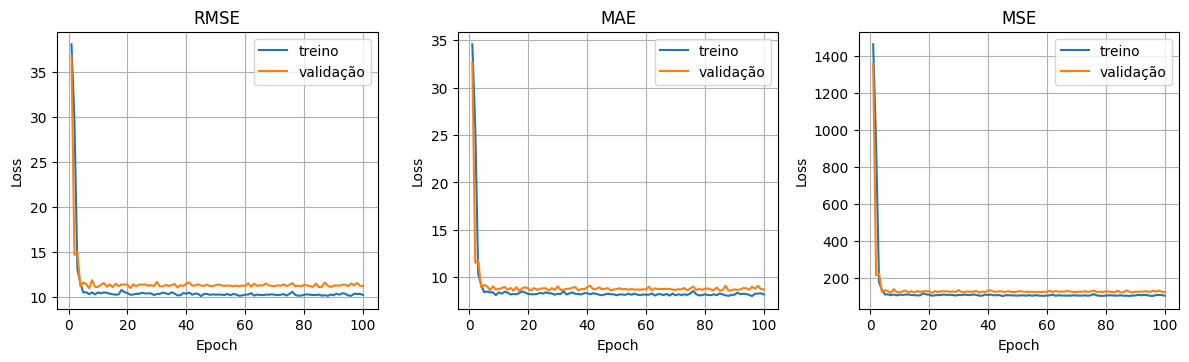

In [412]:
fig, ax = plt.subplots(3, 3, figsize=(12, 10))
ax = ax.flatten()

loss_names = ['rmse', 'mae', 'mse']  # nomes exibidos
epochs = range(1, len(model.perdas[0]) + 1)

for idx, (lt, lv, name) in enumerate(zip(model.perdas, model.perdas_val, loss_names)):
    ax[idx].plot(epochs, lt, label='treino')
    ax[idx].plot(epochs, lv, label='validação')

    ax[idx].set_title(name.upper())
    ax[idx].set_xlabel('Epoch')
    ax[idx].set_ylabel('Loss')
    ax[idx].grid(True)
    ax[idx].legend()

# remove subplots não utilizados
for j in range(len(loss_names), 9):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()


In [413]:
pred = model.predict(xtest)

In [414]:
print(f'''
Dados de testes 

RMSE : {root_mean_squared_error(ytest, pred)}
MAE  : {mean_absolute_error(ytest, pred)}
MSE  : {mean_squared_error(ytest, pred)}
''')


Dados de testes 

RMSE : 10.723361216284626
MAE  : 8.44892993678602
MSE  : 114.99047577491729



&nbsp;

------------------

# Questão 2

Considere o conjunto de dados disponível em vowel.csv, organizado em 11 colunas, sendo as 10 primeiras colunas os atributos e a última coluna a saída. Os 10 atributos referem-se à caracterização de amostras da fala de britânicos. A saída é o fonema de vogal correspondente, dentre as 11 possibilidades.

a. a. Considere um modelo de regressão não linear baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste (por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo abaixo:  
*  MLP (multilayer perceptron): 1 camada oculta e treinamento em minibatch via gradiente descendente estocástico com termo de
momentum. Utilize o conjunto de validação para ajustar os hiperparâmetros.

In [415]:
data = np.loadtxt(fname='lista\\lista_04_ama\\vowel.csv', delimiter=',')

X = data[:, :10].astype(np.float32)
y = data[:, 10].astype(np.int32)

Dividindo dados de treino, val e teste

In [423]:
xtrain,xtest_total,  ytrain, ytest_total = train_test_split(
    X, y, random_state=42, train_size=0.6, shuffle=True, stratify=y
)
xtest, xval, ytest, yval = train_test_split(
    xtest_total, ytest_total, train_size=0.5, random_state=42, shuffle=True, stratify=ytest_total
)

Metricas para classificacao

In [424]:
from sklearn.metrics import (
    accuracy_score
)

Treinando o modelo

In [439]:
model = MLP(
    xtrain, ytrain, xval, yval, loss=[accuracy_score], tipo='cl', camadas_ocultas=1, momentum=0.9, epochs=150, batch_size=10
)
model.ajuste()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:16


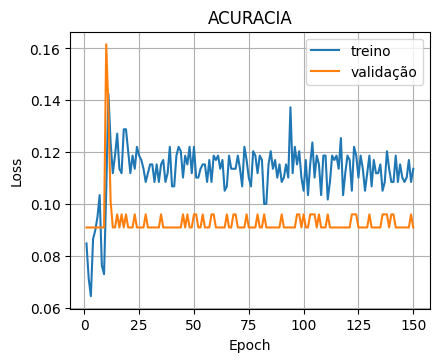

In [440]:
fig, ax = plt.subplots(3, 3, figsize=(12, 10))
ax = ax.flatten()

loss_names = ['acuracia']  # nomes exibidos
epochs = range(1, len(model.perdas[0]) + 1)

for idx, (lt, lv, name) in enumerate(zip(model.perdas, model.perdas_val, loss_names)):
    ax[idx].plot(epochs, lt, label='treino')
    ax[idx].plot(epochs, lv, label='validação')

    ax[idx].set_title(name.upper())
    ax[idx].set_xlabel('Epoch')
    ax[idx].set_ylabel('Loss')
    ax[idx].grid(True)
    ax[idx].legend()

# remove subplots não utilizados
for j in range(len(loss_names), 9):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()


In [441]:
pred = model.predict(xtest)

In [442]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [444]:
accuracy_score(ytest, pred)

0.09090909090909091

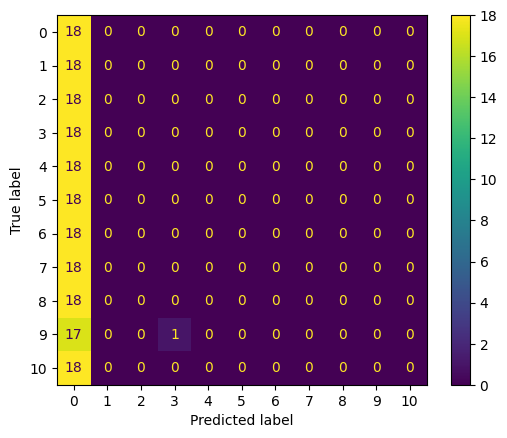

In [443]:
ConfusionMatrixDisplay(confusion_matrix(ytest, pred )).plot()